In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from vlnce_baselines.config.default import get_config
from vlnce_baselines import utils

split = ["val_seen"]

eval_dir = "data/checkpoints/normal/dt_08_sparse_reward_to_go/evals"

t = utils.get_result_files_per_datasplit(eval_dir)
r = utils.read_results_per_split(t)
print(r)

{'val_seen_80_ep': ([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],     distance_to_goal  success       spl      ndtw  path_length  \
12         10.111622   0.1250  0.114806  0.389845     9.093852   
13          8.649552   0.2000  0.189744  0.439005     7.434539   
14          9.140552   0.1625  0.148264  0.435443     7.551964   
15          8.895913   0.1500  0.135305  0.438540     7.486270   
16          9.217857   0.1500  0.141507  0.431523     7.840463   
17          9.869805   0.1500  0.144874  0.393584     7.096036   
18          9.170399   0.1375  0.131429  0.394638     8.076480   
19          9.201326   0.1875  0.183510  0.417051     7.824394   
20          8.213829   0.2500  0.232366  0.483533     7.308966   
21          8.895409   0.1625  0.147153  0.452775     7.226515   
22          8.604158   0.2125  0.199141  0.462532     6.713230   
23          9.029503   0.1750  0.155812  0.444552     7.404824   
24          9.300750   0

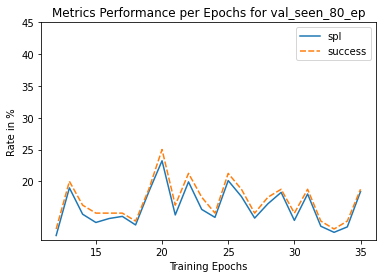

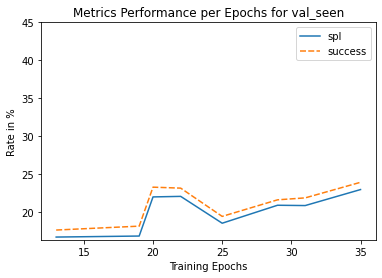

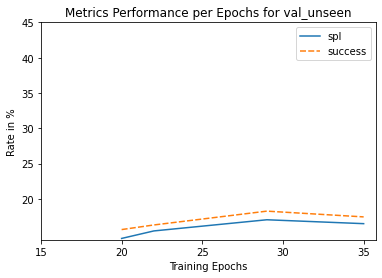

In [3]:
import seaborn as sns

def plot(frame, filter = ["spl", "oracle_success", "success", "ndtw"], xticks=[ 15 , 20,25,30,35]):
    
    data = frame[filter]
    plt.figure() 
    graph = sns.lineplot(data=data*100)
    graph.set(xticks=xticks, yticks=[ 20, 25, 30, 35, 40, 45])
    graph.set(xlabel ="Training Epochs", ylabel = "Rate in %", title =f'Metrics Performance per Epochs for {split}')

filter = ["spl", "success"]
    
for split in r.keys():
    frame = r[split][1]
    plot(frame, filter)
    


In [74]:
import os

def list_best_result_all(result_dir, split, criteria, transformer_type=["normal", "enhanced", "full"], eval_dir="evals", col_ordering = ["path_length", "distance_to_goal", "ndtw", "oracle_success", "success", "spl"], allowed_split=["val_seen", "val_unseen"], sort_reverse=True):
    res_dict = {}
    keep_n_best = 1
    for upper_dir in transformer_type:
        path = os.path.join(result_dir, upper_dir)
        if os.path.exists(path):
            l = [d for d in os.listdir(path) if not d.startswith(".") and not d.startswith("_")]
            if len(l) > 0:
                for model in l:
                    model_result_dir = os.path.join(path, model, eval_dir)
                    if os.path.exists(model_result_dir):
                        res_dict[model_result_dir] = {}
                        result_files = utils.get_result_files_per_datasplit(model_result_dir)
                        result_table = utils.read_results_per_split(result_files)
                        if result_table is not None:
                            res_dict[model_result_dir] = result_table

    best_score = 0.0
    best_model = "No model found"
    all_best = {}
    for model_result_dir in res_dict.keys():
        if split in res_dict[model_result_dir].keys():
            _, frame = res_dict[model_result_dir][split]
            best_index = frame[criteria].nlargest(keep_n_best)
            current_res = frame[criteria][best_index.index]
            metrics = current_res.values[0]

            all_res = {s:res_dict[model_result_dir][s][1].loc[best_index.index].reindex(columns=col_ordering) for s in res_dict[model_result_dir].keys() if s in allowed_split}
            all_res = pd.concat(all_res, axis=1)
            all_best[model_result_dir] = metrics, best_index.index.values[0], all_res
            if metrics >= best_score:
                best_score = metrics
                best_model = model_result_dir

    print("Best:", best_model, split, best_score)
    return dict(sorted(all_best.items(), key=lambda item: item[1][0], reverse=sort_reverse))

In [75]:
# https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
# https://stackoverflow.com/questions/18528533/pretty-printing-a-pandas-dataframe
from IPython.display import display, HTML

transformer_type = ["normal", "enhanced", "full"]  # ["normal", "enhanced", "full"]
split = "val_unseen"
result_dir = "results/decision_transformer"
criteria = "spl"
# TL NE nDTW OS SR SP => "path_length", "distance_to_goal", "ndtw", "oracle_success", "success", "spl"
# "distance_to_goal", " success", "spl",  "ndtw", "path_length" , "oracle_success", "steps_taken"
# 
all_best_res = list_best_result_all(result_dir, split, criteria, transformer_type)

it = len(all_best_res)
print(f"\n################  {it}  results retrieved for {split} #################\n")


for k, v in all_best_res.items():
    print(f"\n{it}: " + k.split("decision_transformer/")[1].split("/evals")[0], ",epoch:", v[1], f",best {criteria}:", v[0])
    # print({k: v[2][k].values[0] for k in v[2].keys() if k not in [criteria, "oracle_success", "path_length"]})
    display(HTML(v[2].to_html()))
    it -= 1


Best: results/decision_transformer/normal/dt_08_d512_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat/evals val_unseen 0.21102034437422515

################  151  results retrieved for val_unseen #################


151: normal/dt_08_d512_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat ,epoch: 75 ,best spl: 0.21102034437422515



150: normal/dt_08_d512_l8_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat ,epoch: 107 ,best spl: 0.20912843681619592



149: full/full_08_d512_sparse_reward_to_go_enc_l8_dagger_it10_ep12_p0_75_pof_oat_aug_5epochs ,epoch: 86 ,best spl: 0.18473034086062012



148: enhanced/enhanced_08_d512_l10_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat_pretrained_aug_5epochs ,epoch: 104 ,best spl: 0.18302642361974922



147: enhanced/enhanced_08_d512_l10_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat_pretrained_aug ,epoch: 85 ,best spl: 0.18201103899084967



146: normal/dt_08_d512_l8_h16_sparse_reward_to_go ,epoch: 38 ,best spl: 0.18155361002162387



145: enhanced/enhanced_08_d512_l10_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat ,epoch: 89 ,best spl: 0.17769203449073243



144: normal/dt_08_d512_l8_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat_pretrained_aug_5epochs ,epoch: 115 ,best spl: 0.17763373765277293



143: normal/dt_08_sparse_reward_to_go_dagger_it10_ep10_p0_75 ,epoch: 53 ,best spl: 0.17647386441967822



142: normal/dt_08_d512_sparse_reward_to_go_0_1_dagger_it10_ep12_p0_75_pof_oat ,epoch: 95 ,best spl: 0.1709771187410098



141: normal/dt_08_sparse_reward_to_go ,epoch: 29 ,best spl: 0.17048995054697685



140: normal/dt_08_d512_sparse_reward_to_go ,epoch: 31 ,best spl: 0.1667826076874978



139: normal/dt_08_sparse_reward_to_go_spatial ,epoch: 30 ,best spl: 0.1655030267955549



138: full/full_08_d512_sparse_reward_to_go_enc_l8_dagger_it10_ep12_p0_75_pof_oat_aug ,epoch: 71 ,best spl: 0.16525088022262746



137: normal/dt_08_d512_l8_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat_pretrained_aug ,epoch: 116 ,best spl: 0.16491023902115295



136: normal/dt_08_sparse_reward_to_go_dagger_it10_ep10_p0_85 ,epoch: 55 ,best spl: 0.16474884291831846



135: full/full_08_d512_sparse_reward_to_go_enc_l8_dagger_it10_ep12_p0_75_pof_oat ,epoch: 49 ,best spl: 0.16390566912411803



134: normal/dt_08_d512_sparse_reward_to_go_0_1_dagger_it10_ep12_p0_75_pot_oaf ,epoch: 95 ,best spl: 0.1632335859970299



133: normal/dt_08_d512_sparse_reward_to_go_dagger_it10_ep12_p0_75_pot_oat ,epoch: 119 ,best spl: 0.16302699793438244



132: full/full_08_sparse_reward_to_go_enc_l6_h16 ,epoch: 9 ,best spl: 0.1628341275997464



131: full/full_08_d512_sparse_reward_to_go_enc_l8 ,epoch: 12 ,best spl: 0.16269669514112353



130: full/full_08_d512_sparse_reward_to_go_enc_l8_h16 ,epoch: 12 ,best spl: 0.16269669514112353



129: enhanced/enhanced_b08_512_sparse_reward_l10_h16_enc_transformer ,epoch: 19 ,best spl: 0.16167546851981104



128: normal/dt_08_d512_sparse_reward_to_go_dagger_it10_ep12_p0_65_pof_oat ,epoch: 84 ,best spl: 0.16157161244659102



127: full/full_dt_b08_512_sparse_reward_all_enc_l08_h16 ,epoch: 14 ,best spl: 0.16014565867992936



126: full/full_dt_b08_512_sparse_reward_all_enc_l06_h16 ,epoch: 6 ,best spl: 0.16004213714207316



125: full/full_08_sparse_reward_to_go_enc_l6 ,epoch: 9 ,best spl: 0.15957148485912653



124: normal/dt_08_d1024_l12_h16 ,epoch: 44 ,best spl: 0.15903116192293892



123: full/full_dt_b08_512_sparse_reward_inst_enc_l10_h16_gpt_l6_h16 ,epoch: 13 ,best spl: 0.15840690291554488



122: enhanced/enhanced_08_d512_10l_h16 ,epoch: 23 ,best spl: 0.15837739786819952



121: normal/dt_08_d512_8l_h16 ,epoch: 32 ,best spl: 0.15788690809516545



120: enhanced/enhanced_08_d512_12l_h16 ,epoch: 22 ,best spl: 0.15763076098969245



119: normal/dt_08_d512 ,epoch: 28 ,best spl: 0.1574183829008003



118: full/full_08_sparse_reward_to_go_spatial ,epoch: 14 ,best spl: 0.15734224162223076



117: normal/dt_08_d512_sparse_reward_to_go_dagger_it10_ep10_p0_65_pot_oat ,epoch: 82 ,best spl: 0.15730577349413646



116: normal/dt_08_d512_6l ,epoch: 33 ,best spl: 0.1556685617121953



115: normal/dt_08_d1024_l12_h16_sparse_reward_to_go ,epoch: 30 ,best spl: 0.1553246216326894



114: enhanced/enhanced_b08_512_sparse_reward_l8_h16_enc_transformer ,epoch: 22 ,best spl: 0.15532359858919836



113: normal/dt_08_sparse_reward_to_go_0.1 ,epoch: 20 ,best spl: 0.1552274910031391



112: normal/dt_08_sparse_reward_to_go_dagger_it06_ep30_p0.75_d128.yaml ,epoch: 93 ,best spl: 0.15513774406997263



111: full/full_08_d512_sparse_reward_to_go_tr_enc_l8_h16 ,epoch: 10 ,best spl: 0.15472003579859017



110: full/full_08_sparse_reward_to_go ,epoch: 8 ,best spl: 0.1543856051599561



109: normal/dt_08_sparse_reward_to_go_dagger_it10_ep10_p0_95 ,epoch: 52 ,best spl: 0.15335857214308837



108: full/full_dt_attention_ablation_b16_rgb_depth_instruct ,epoch: 18 ,best spl: 0.15324698101882447



107: normal/dt_08_sparse_reward_to_go_enc_lstm ,epoch: 41 ,best spl: 0.15318249358955024



106: enhanced/enhanced_08_d512_8l_h16 ,epoch: 25 ,best spl: 0.15314699695569042



105: enhanced/enhanced_b08_512_sparse_reward_l10_h16_enc_transformer_aug ,epoch: 26 ,best spl: 0.15308471287432412



104: normal/dt_08_sparse_reward_to_go_rezero ,epoch: 35 ,best spl: 0.15256850325598698



103: normal/dt_08_no_reward ,epoch: 33 ,best spl: 0.1522893998943468



102: full/full_08_sparse_reward_to_go_enc_l10 ,epoch: 24 ,best spl: 0.15226349465622985



101: enhanced/enhanced_b08_128_sparse_reward_enc_transformer ,epoch: 35 ,best spl: 0.15198338230461322



100: full/full_dt_b16_rgb_depth_instruct_512_8l_h16 ,epoch: 11 ,best spl: 0.1513303472220286



99: full/full_dt_b16_128_sparse_reward_rgb_depth_instruct ,epoch: 8 ,best spl: 0.15065385728222813



98: full/full_08_d512_sparse_reward_to_go_enc_l10 ,epoch: 9 ,best spl: 0.15007189225372514



97: full/full_08_sparse_reward_to_go_enc_l8 ,epoch: 19 ,best spl: 0.1498918190435889



96: normal/dt_08_sparse_reward_to_go_0.5 ,epoch: 27 ,best spl: 0.14982171957408416



95: full/full_dt_b16_rgb_depth_instruct_1024_6l_h16 ,epoch: 11 ,best spl: 0.14964621045076995



94: normal/dt_08_d1024 ,epoch: 41 ,best spl: 0.14954752244723218



93: full/full_08_d512_sparse_reward_to_go_enc_l10_h16 ,epoch: 3 ,best spl: 0.1493929024832948



92: normal/dt_08_d512_no_iw ,epoch: 13 ,best spl: 0.14863575912907318



91: full/full_dt_b08_512_sparse_reward_all_enc_l08_h16_rezero ,epoch: 5 ,best spl: 0.1484033777091478



90: normal/dt_08_d512_10l_h16 ,epoch: 38 ,best spl: 0.14830928331597115



89: full/full_dt_b16_rgb_depth_instruct_1024 ,epoch: 8 ,best spl: 0.14781725779089477



88: full/full_dt_b16_128_no_reward_rgb_depth_instruct ,epoch: 30 ,best spl: 0.147565380871578



87: full/full_08_no_reward ,epoch: 17 ,best spl: 0.1469612562700325



86: enhanced/dt_enhanced_b8_d1024 ,epoch: 21 ,best spl: 0.14655184344645733



85: full/full_dt_b8_d512 ,epoch: 5 ,best spl: 0.14566966641019152



84: full/full_08_d512_sparse_reward_to_go_tr_enc_l6_h16 ,epoch: 8 ,best spl: 0.14527883502922456



83: enhanced/enhanced_b08_128_sparse_reward_0.1_enc_transformer ,epoch: 23 ,best spl: 0.14518786442682172



82: full/full_dt_b16_rgb_depth_instruct_1024_10l_h16 ,epoch: 9 ,best spl: 0.1446513172599612



81: normal/dt_08_sparse_reward_to_go_0.25 ,epoch: 35 ,best spl: 0.14415067481552107



80: full/full_dt_b16_rgb_depth_instruct_512 ,epoch: 12 ,best spl: 0.14411806837679608



79: enhanced/enhanced_b08_512_sparse_reward_l10_h16_enc_transformer_aug_5epochs ,epoch: 2 ,best spl: 0.14378198301082057



78: full/full_dt_b16_rgb_depth_instruct_256 ,epoch: 9 ,best spl: 0.14308692191559239



77: normal/dt_08 ,epoch: 19 ,best spl: 0.14277362083406833



76: enhanced/dt_enhanced_batch_8_d128 ,epoch: 37 ,best spl: 0.14264343811137092



75: enhanced/dt_enhanced_batch_16_d128 ,epoch: 11 ,best spl: 0.14190743564484504



74: full/full_08_d512_sparse_reward_to_go_enc_l6 ,epoch: 9 ,best spl: 0.14187830200588142



73: full/full_dt_b8_d256 ,epoch: 9 ,best spl: 0.1405211980116617



72: full/full_08_d512_sparse_reward_to_go_tr_enc_l10_h16 ,epoch: 12 ,best spl: 0.14004514732849893



71: full/full_dt_b08_512_sparse_reward_all_enc_l10_h16 ,epoch: 9 ,best spl: 0.13994468220338988



70: full/full_dt_sparse_to_go_attention_ablation_b8_depth_instruct ,epoch: 13 ,best spl: 0.13977160186579324



69: full/full_08_d512_sparse_reward_to_go_enc_l8_aug ,epoch: 15 ,best spl: 0.13963987378419365



68: enhanced/enhanced_b16_128_no_reward ,epoch: 39 ,best spl: 0.13950599012113438



67: full/full_sv_b16_d512_state_instruct ,epoch: 8 ,best spl: 0.13935461566949572



66: full/full_dt_sparse_to_go_attention_ablation_b8_rgb_depth_instruct ,epoch: 11 ,best spl: 0.13922045030409758



65: enhanced/dt_enhanced_b8_d256 ,epoch: 25 ,best spl: 0.13904635116959588



64: enhanced/enhanced_08_d512_6l_h16 ,epoch: 11 ,best spl: 0.1389987442836407



63: enhanced/enhanced_b08_128_sparse_reward_enc_transformer_50_plus ,epoch: 5 ,best spl: 0.13875625000536101



62: full/full_dt_b16_rgb_depth_instruct_512_10l_h16 ,epoch: 8 ,best spl: 0.13866764484623956



61: enhanced/dt_enhanced_b8_d512 ,epoch: 19 ,best spl: 0.1383354132457982



60: full/full_dt_sparse_to_go_attention_ablation_b8_rgb_instruct ,epoch: 30 ,best spl: 0.1382018512558086



59: full/full_dt_sparse_to_go_attention_ablation_b8_rgb_state ,epoch: 10 ,best spl: 0.1376488127822556



58: full/full_dt_b16_rgb_depth_instruct_512_6l_h16 ,epoch: 11 ,best spl: 0.13722727210950064



57: enhanced/enhanced_b08_128_sparse_reward_0.5_enc_transformer ,epoch: 41 ,best spl: 0.13700192448162898



56: normal/dt_08_sparse_reward_to_go_50_plus ,epoch: 8 ,best spl: 0.13681883335312894



55: full/dt_full_b16_d512 ,epoch: 11 ,best spl: 0.13681383921385123



54: full/full_08_sparse_reward_to_go_50_plus ,epoch: 4 ,best spl: 0.13669556726793833



53: full/full_dt_attention_ablation_b16_rgb_state ,epoch: 31 ,best spl: 0.13631840587109686



52: full/full_dt_b16_128_no_reward ,epoch: 7 ,best spl: 0.13627002127610166



51: full/full_08_d512_sparse_reward_to_go ,epoch: 4 ,best spl: 0.13607426729571817



50: full/full_dt_attention_ablation_b16_rgb_instruct ,epoch: 35 ,best spl: 0.13537779581553203



49: full/full_dt_b16_rgb_depth_instruct_1024_8l_h16 ,epoch: 5 ,best spl: 0.13507353175076964



48: full/full_dt_attention_ablation_b8_rgb_depth_instruct ,epoch: 21 ,best spl: 0.13420156901771518



47: enhanced/enhanced_b16_128_sparse_reward ,epoch: 41 ,best spl: 0.13406976434996398



46: full/full_sv_b08_d512_state_instruct_sparse_to_go ,epoch: 15 ,best spl: 0.1338558110171262



45: full/full_dt_batch_8_d128 ,epoch: 25 ,best spl: 0.13333555269051914



44: normal/dt_08_d512_l8_h16_sparse_reward_aug ,epoch: 16 ,best spl: 0.1329513528417031



43: full/full_dt_sparse_to_go_attention_ablation_b8_depth_state ,epoch: 23 ,best spl: 0.13284929670616863



42: normal/dt_05 ,epoch: 23 ,best spl: 0.1320867838439732



41: full/full_dt_b16_d512 ,epoch: 7 ,best spl: 0.13170724906587195



40: full/full_08_d512_sparse_reward_to_go_enc_l8_aug_5epochs ,epoch: 1 ,best spl: 0.13141422527510008



39: full/full_dt_attention_ablation_b8_depth_instruct ,epoch: 22 ,best spl: 0.13125177292980073



38: full/full_dt_sparse_to_go_attention_ablation_b8_rgb_depth_state ,epoch: 20 ,best spl: 0.12999440565613843



37: full/full_dt_attention_ablation_b8_rgb_instruct ,epoch: 24 ,best spl: 0.12881891607520393



36: normal/dt_08_d512_l8_h16_sparse_reward_aug_5epochs ,epoch: 3 ,best spl: 0.12846819149081548



35: enhanced/dt_enhanced_batch_32_d128 ,epoch: 27 ,best spl: 0.12840658583564038



34: enhanced/dt_enhanced_batch_64_d128 ,epoch: 29 ,best spl: 0.12783413304965252



33: full/full_dt_batch_16_d128 ,epoch: 26 ,best spl: 0.12773081317514287



32: full/full_dt_attention_ablation_b16_depth_instruct ,epoch: 33 ,best spl: 0.12752397969021498



31: normal/dt_06 ,epoch: 25 ,best spl: 0.12529554857913627



30: full/full_dt_b16_rgb_depth_instruct_1024_12l_h16 ,epoch: 6 ,best spl: 0.12330610903621501



29: normal/dt_64 ,epoch: 52 ,best spl: 0.12200748533977365



28: full/full_dt_b16_rgb_depth_instruct_512_12l_h16 ,epoch: 15 ,best spl: 0.12198126169517758



27: full/decision_transformer_debug_rgb_depth_mean ,epoch: 20 ,best spl: 0.12170963119638173



26: normal/dt_08_d512_l8_h16_sparse_reward_to_go_fine_aug ,epoch: 765971 ,best spl: 0.12066177548562028



25: normal/dt_32 ,epoch: 31 ,best spl: 0.11962583242597555



24: normal/dt_08_d256 ,epoch: 39 ,best spl: 0.11957624792502416



23: normal/dt_08_d512_lr2-05 ,epoch: 49 ,best spl: 0.11895768697907065



22: full/full_dt_attention_ablation_b8_rgb_state ,epoch: 7 ,best spl: 0.11870848800186273



21: full/full_dt_attention_ablation_b16_depth_state ,epoch: 35 ,best spl: 0.11860247587054029



20: full/full_dt_b16_rgb_depth_instruct_action ,epoch: 21 ,best spl: 0.11795076958430906



19: full/dt_full_b16_d256 ,epoch: 14 ,best spl: 0.11786758344676287



18: full/full_dt_b16_128_sparse_reward ,epoch: 23 ,best spl: 0.11689301142256411



17: full/full_dt_attention_ablation_b8_depth_state ,epoch: 10 ,best spl: 0.1168102566385515



16: normal/dt_16 ,epoch: 24 ,best spl: 0.11446558504101201



15: full/decision_transformer_debug_rgb_mean ,epoch: 7 ,best spl: 0.11397454709038042



14: full/full_dt_attention_ablation_b8_rgb_depth_state ,epoch: 4 ,best spl: 0.11347644517567408



13: full/full_dt_batch_32_d128 ,epoch: 31 ,best spl: 0.10610323524432466



12: full/full_dt_b16_d256 ,epoch: 5 ,best spl: 0.10543098556595226



11: full/full_dt_attention_ablation_b16_rgb_depth_state ,epoch: 26 ,best spl: 0.10025047114254394



10: full/decision_transformer_debug_depth_mean ,epoch: 8 ,best spl: 0.0990887364334951



9: full/full_dt_batch_64_d128 ,epoch: 29 ,best spl: 0.09358725894623536



8: enhanced/enhanced_b16_128_ndtw_reward ,epoch: 24 ,best spl: 0.07868848973010306



7: normal/dt_08_sparse_reward_to_go_aug ,epoch: 34 ,best spl: 0.07392544633310821



6: normal/dt_08_sparse_reward_to_go_10.0 ,epoch: 17 ,best spl: 0.0631073810421687



5: normal/dt_08_ndtw_reward_to_go ,epoch: 23 ,best spl: 0.06079520786183965



4: full/full_08_ndtw_reward_to_go ,epoch: 8 ,best spl: 0.0568019693070326



3: normal/dt_08_ndtw_only ,epoch: 35 ,best spl: 0.05321805558435555



2: enhanced/enhanced_08_ndtw_only ,epoch: 16 ,best spl: 0.04756467077697579



1: full/full_08_ndtw_only ,epoch: 8 ,best spl: 0.04640468744022106


In [107]:
# https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
# https://stackoverflow.com/questions/18528533/pretty-printing-a-pandas-dataframe

def get_report_config(config_filepath):
    
    conf_node = get_config(config_filepath)

    
    model_conf = conf_node.MODEL.DECISION_TRANSFORMER
    training_conf = conf_node.IL
    
    default = "_"
    default_yes = "yes"
    instruction_encoding = "transformer"
    instruction_n_head = default
    instruction_n_layer = default
    instruction_dim = default
    
    main_task = conf_node.BASE_TASK_CONFIG_PATH.split("/")[-1].split(".")[0]
    env_drop = default
    if "aug" in main_task:
        env_drop = default_yes
    
    net = model_conf.net
    
    if net == 'DecisionTransformerNet':
        net = "DT"
    if net == 'DecisionTransformerEnhancedNet':
        net = "Enhanced"
    if net == 'FullDecisionTransformerNet':
        net = "Full"
    if model_conf.net in ['DecisionTransformerNet', 'DecisionTransformerEnhancedNet']:
        if model_conf.use_transformer_encoded_instruction:
            instruction_encoding = "transformer"
            instruction_n_head = conf_node.MODEL.DECISION_TRANSFORMER.ENCODER.n_head
            instruction_n_layer = conf_node.MODEL.DECISION_TRANSFORMER.ENCODER.n_layer
            instruction_dim = conf_node.MODEL.DECISION_TRANSFORMER.hidden_dim
        else:
            instruction_encoding = "lstm"
            instruction_dim = conf_node.MODEL.INSTRUCTION_ENCODER.hidden_size
        
    else:
        instruction_n_head = "Same as GPT"
        instruction_n_layer = "Same as GPT"
        instruction_dim = "Same as GPT"

    reward_type = model_conf.reward_type.split("_to_go")[0].upper()
    # work around for early inconsistence in the project
    if reward_type == "POINT_NAV_REWARD":
        reward_type = "POINT_GOAL_NAV_REWARD"
    display_reward = " ".join(reward_type.split("_REWARD")[0].split("_"))


    use_dagger = default
    dagger_iterations = default
    dagger_update_size = default
    dagger_oa = default
    dagger_pe = default

    if not training_conf.DAGGER.preload_lmdb_features:
        use_dagger = default_yes
        dagger_iterations = training_conf.DAGGER.iterations
        dagger_update_size = training_conf.DAGGER.update_size
        dagger_oa = training_conf.DECISION_TRANSFORMER.use_oracle_actions
        dagger_pe = training_conf.DECISION_TRANSFORMER.use_perfect_episode_only_for_dagger

    pretraining = default
    pretraining_name = default    
    if training_conf.load_from_ckpt:
        pretraining = default_yes
        pretraining_name = training_conf.ckpt_to_load.split("/ckpt")[0].split("/")[-1]

    displayed_conf = {"Model": net,
                  "Batch Size": training_conf.batch_size,
    "GPT Heads": model_conf.n_head,
    "GPT Layer": model_conf.n_layer,
    "GPT Dim": model_conf.hidden_dim,
                 "Instruction Encoding": instruction_encoding,
                 "Instruction Heads": instruction_n_head,
                 "Instruction Layers": instruction_n_layer,
                 "Instruction Dim": instruction_dim,
                 "Reward Type": display_reward,
                 "Reward Step Penalty": training_conf.DECISION_TRANSFORMER[reward_type].step_penalty,
                 "Reward Success":  training_conf.DECISION_TRANSFORMER[reward_type].success,
                 "DAGGER": use_dagger,
                 "DAGGER Iterations": dagger_iterations,
                 "DAGGER Update Size": dagger_update_size,
                 "DAGGER Oracle Actions": dagger_oa,
                 "DAGGER Perfect Episodes": dagger_pe,
                 "AUG": env_drop,
                 "Pre-training": pretraining,
                 "Pre-training Config": pretraining_name
                     }
    
    return displayed_conf


def get_config_and_results_for_print(all_best_res):

    it = len(all_best_res)
    print(f"\n################  {it}  results retrieved for {split} #################\n")
    report_conf_list = []
    report_result_list = []
    id = 1
    config_col_name = "#"
    for k, v in all_best_res.items():
        config_file_name = k.split(main_folder + "/")[1].split("/evals")[0].split("/")[1]
        #print(f"\n{it}: " + config_file_name +",epoch:", v[1], f",best {criteria}:", v[0])
        
        config_filepath = os.path.join(config_dir, config_file_name+".yaml")
        if os.path.exists(config_filepath):
            report_conf = get_report_config(config_filepath)
            report_conf_list.append(report_conf)
        else:
            print(f"Config not found: {config_filepath}")
            continue
        # print({k: v[2][k].values[0] for k in v[2].keys() if k not in [criteria, "oracle_success", "path_length"]})
        v[2].insert(loc=0, column=config_col_name, value=id)
        report_result_list.append(v[2])
        # display(HTML(v[2].to_html()))
        #print(v[2].to_markdown())
        it -= 1
        id += 1

    report_conf_list = pd.DataFrame.from_dict(report_conf_list)
    report_conf_list.insert(loc=0, column=config_col_name, value=report_conf_list.index + 1)
    report_result_list = pd.concat(report_result_list)
    
    return report_conf_list, report_result_list
    #display(HTML(report_result_list.to_html(index=False)))
    #display(HTML(report_conf_list.to_html(index=False)))

def html_display(df):
    display(HTML(df.to_html(index=False)))

        
from IPython.display import display, HTML

transformer_type = ["normal", "enhanced", "full"]  # ["normal", "enhanced", "full"]
split = "val_unseen"
#main_folder = "checkpoints"
main_folder = "decision_transformer"
# result_dir = "../data/" + main_folder
result_dir = "results/"+main_folder
criteria = "spl"

config_dir = "vlnce_baselines/config/r2r_baselines/decision_transformer/all/"
# TL NE nDTW OS SR SP => "path_length", "distance_to_goal", "ndtw", "oracle_success", "success", "spl"
# "distance_to_goal", " success", "spl",  "ndtw", "path_length" , "oracle_success", "steps_taken"
#
all_best_res = list_best_result_all(result_dir, split, criteria,
                                    transformer_type)

report_conf_list, report_result_list = get_config_and_results_for_print(all_best_res)


Best: results/decision_transformer/normal/dt_08_d512_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat/evals val_unseen 0.21102034437422515

################  151  results retrieved for val_unseen #################

Config not found: vlnce_baselines/config/r2r_baselines/decision_transformer/all/enhanced_08_d512_l10_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat_pretrained_aug_5epochs.yaml
Config not found: vlnce_baselines/config/r2r_baselines/decision_transformer/all/enhanced_08_d512_l10_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat_pretrained_aug.yaml
Config not found: vlnce_baselines/config/r2r_baselines/decision_transformer/all/enhanced_08_d512_l10_h16_sparse_reward_to_go_dagger_it10_ep12_p0_75_pof_oat.yaml
Config not found: vlnce_baselines/config/r2r_baselines/decision_transformer/all/dt_08_d512_sparse_reward_to_go_0_1_dagger_it10_ep12_p0_75_pot_oaf.yaml
Config not found: vlnce_baselines/config/r2r_baselines/decision_transformer/all/full_08_sparse_reward_to_go_enc

In [108]:
html_display(report_conf_list)

#,Model,Batch Size,GPT Heads,GPT Layer,GPT Dim,Instruction Encoding,Instruction Heads,Instruction Layers,Instruction Dim,Reward Type,Reward Step Penalty,Reward Success,DAGGER,DAGGER Iterations,DAGGER Update Size,DAGGER Oracle Actions,DAGGER Perfect Episodes,AUG,Pre-training,Pre-training Config
1,DT,8,8,3,512,transformer,8,3,512,SPARSE,-0.05,1.00,yes,10,5000,True,False,_,_,_
2,DT,8,16,8,512,transformer,8,3,512,SPARSE,-0.05,1.00,yes,10,5000,True,False,_,_,_
3,Full,8,8,3,512,transformer,Same as GPT,Same as GPT,Same as GPT,SPARSE,-0.05,1.00,yes,0,5000,True,False,_,yes,full_08_d512_sparse_reward_to_go_enc_l8_aug_5epochs
4,DT,8,16,8,512,transformer,8,3,512,SPARSE,-0.05,1.00,_,_,_,_,_,_,_,_
5,DT,8,16,8,512,transformer,8,3,512,SPARSE,-0.05,1.00,yes,10,5000,True,False,_,yes,dt_08_d512_l8_h16_sparse_reward_aug_5epochs
6,DT,8,16,8,512,transformer,8,3,512,SPARSE,-0.05,1.00,yes,10,5000,False,True,_,_,_
7,DT,8,8,3,512,transformer,8,3,512,SPARSE,-0.05,0.10,yes,10,5000,True,False,_,_,_
8,DT,8,8,3,128,transformer,8,3,128,SPARSE,-0.05,1.00,_,_,_,_,_,_,_,_
9,DT,8,8,3,512,transformer,8,3,512,SPARSE,-0.05,1.00,_,_,_,_,_,_,_,_
10,DT,8,8,3,128,transformer,8,3,128,SPARSE,-0.05,1.00,_,_,_,_,_,_,_,_


In [109]:
html_display(report_result_list)

MODEL
net
hidden_dim: 128
n_embd: 128
n_head: 8
n_layer: 3
use_transformer_encoded_instruction
ENCODER: # 'DecisionTransformerNet', 'DecisionTransformerEnhancedNet'
  n_head: 8
  n_layer: 3
return_to_go_inference
reward_type

CONFIG

batch_size
load_from_ckpt (for Pretrained / Finetuning)

DAGGER:
  preload_lmdb_features: True
  iterations
  update_size
DECISION_TRANSFORMER:
  NDTW_REWARD:
    step_penalty: -0.05
    success: 1.0
  POINT_GOAL_NAV_REWARD:
    step_penalty: -0.05
    success: 1.0
  SPARSE_REWARD:
    step_penalty: -0.05
    success: 1.0
   reward_type: POINT_GOAL_NAV_REWARD
  use_oracle_actions: False # DAGGER ONLY
  use_perfect_episode_only_for_dagger # DAGGER ONLY
  
env drop, yes no 


In [55]:

print(displayed_conf)

{'Model': 'DecisionTransformerNet', 'Batch Size': 8, 'GPT heads': 8, 'GPT layer': 3, 'GPT dim': 128, 'Instruction encoding': 'transformer', 'Instruction heads': '_', 'Instruction layers': '_', 'Instruction dim': '_', 'Reward Type': 'NDTW', 'Reward Step Penalty': -0.05, 'Reward Success': 1.0, 'DAGGER': '_', 'DAGGER iterations': '_', 'DAGGER update size': '_', 'DAGGER oracle actions': '_', 'DAGGER perfect episodes': '_', 'pretraining': '_', 'pretraining_name': '_'}


In [54]:
"data/checkpoints/normal/dt_08_ndtw_only/ckpt.269.pth"

'dt_08_ndtw_only'